### How many of the new lncRNA genes get tested for eQTLs? How many are eGenes?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from tqdm import tqdm
from matplotlib.lines import Line2D
import upsetplot as up
import matplotlib.ticker as mticker


In [2]:
# Load in tissue colors 
with open('/home/klawren/oak/gtex/data/other_references/gtex_colors.json') as f:
    tissue_df = pd.DataFrame.from_dict(json.load(f), orient='index')
tissue_df = tissue_df.reset_index(names='tissue_name')
tissue_df['tissue_color_hex'] = '#' + tissue_df['tissue_color_hex']
tissue_color_palette = sns.color_palette(tissue_df['tissue_color_hex'])

# get the versions of tissue ids in file names
tissue_df['tissue_file_name'] = (
    tissue_df['tissue_name']
    .str.replace('(', '', regex=False)
    .str.replace(')', '', regex=False)
    .str.replace(' - ', '_')
    .str.replace(' ', '_')
)

gene_type_pal= {'lncRNA':'#b70657',
                            'sRNA':'#2D716F',
                            'pseudogene':'#734675',
                            'protein_coding':'#016895', 
                            'artifact':'grey'}

                            
gene_type_order_highlight = ['new_lncRNA', 'existing_lncRNA', 'protein_coding', 'pseudogene', 'sRNA']

# Use a lighter/greyer version for all except new_lncRNA
gene_type_pal_greyed = {
    'new_lncRNA': '#b70657',         
    'existing_lncRNA': '#d6a5b7',    
    'sRNA': '#b3c6c6',           # lighter/greyer teal
    'pseudogene': '#c2b0c6',     # lighter/greyer purple
    'protein_coding': '#a3b9c6', # lighter/greyer blue
    'artifact': '#cccccc'}        # light grey


tissue_color_map = dict(zip(tissue_df['tissue_name'], tissue_df['tissue_color_hex']))

In [3]:
# bring in gencode ids
gencode_ids = pd.read_table('/home/klawren/oak/gtex/data/other_references/gencode/gencode_id_matching_lncrna_category.txt')
gencode_ids['gene_type_grouped'] = np.where(gencode_ids['gene_type_grouped_highlight'].str.contains('lncRNA'), 'lncRNA', gencode_ids['gene_type_grouped_highlight'])
gencode_ids.head()

/local/scratch/klawren/slrmtmp.48896882/ipykernel_627/944460149.py:2: DtypeWarning: Columns (3,5) have mixed types. Specify dtype option on import or set low_memory=False.
  gencode_ids = pd.read_table('/home/klawren/oak/gtex/data/other_references/gencode/gencode_id_matching_lncrna_category.txt')


,gene_id_stable,lncrna_category,gene_id_v47,gene_id_v39,gene_type_grouped_highlight,gene_type_v39,gene_type_v47,in_v47_full,in_v47_collapsed,in_v39_full,in_v39_collapsed,collapsed_location_change_v47,collapsed_location_change_v39,collapsed_location_change_between_versions,full_location_change_between_versions,gene_type_grouped
0,ENSG00000000003,NaN,ENSG00000000003.16,ENSG00000000003.15,protein_coding,protein_coding,protein_coding,True,True,True,True,False,False,False,False,protein_coding
1,ENSG00000000005,NaN,ENSG00000000005.6,ENSG00000000005.6,protein_coding,protein_coding,protein_coding,True,True,True,True,False,False,False,False,protein_coding
2,ENSG00000000419,NaN,ENSG00000000419.14,ENSG00000000419.14,protein_coding,protein_coding,protein_coding,True,True,True,True,True,True,True,False,protein_coding
3,ENSG00000000457,NaN,ENSG00000000457.14,ENSG00000000457.14,protein_coding,protein_coding,protein_coding,True,True,True,True,False,False,False,False,protein_coding
4,ENSG00000000460,NaN,ENSG00000000460.17,ENSG00000000460.17,protein_coding,protein_coding,protein_coding,True,True,True,True,False,False,False,False,protein_coding


load in egene data

In [18]:
# Load eGene, sGene, and apaGene results for all tissues, minimizing DataFrame fragmentation.
# Instead of inserting columns one by one, collect all columns in dictionaries and concatenate at once.

egene_results_dir = "/home/klawren/oak/gtex/output/qtl/GTEx_Analysis_v11_eQTL"
sqtl_results_dir = "/home/klawren/oak/gtex/output/qtl/GTEx_Analysis_v11_sQTL"
apaqtl_results_dir = "/home/klawren/oak/gtex/output/qtl/GTEx_Analysis_v11_apaQTL"

# Dictionaries to hold new columns for batch insertion
egene_tested_dict = {}
egene_dict = {}
sqtl_tested_dict = {}
sqtl_sgene_dict = {}
apaqtl_tested_dict = {}
apaqtl_apagene_dict = {}

etested_cols = []
egene_cols = []
stested_cols = []
sgene_cols = []
apatested_cols = []
apagene_cols = []

# Load eGene files for all tissues
for id, row in tissue_df.iterrows():
    tissue = row['tissue_file_name']
    try:
        egene_file = pd.read_table(f"{egene_results_dir}/{tissue}.v11.eGenes.txt.gz")
        egene_tested_dict[f'{tissue}.eqtl_tested'] = gencode_ids['gene_id_v47'].isin(egene_file['gene_id'])
        egene_dict[f'{tissue}.eqtl_egene'] = gencode_ids['gene_id_v47'].isin(egene_file[egene_file['qval'] < 0.05]['gene_id'])
        etested_cols.append(f'{tissue}.eqtl_tested')
        egene_cols.append(f'{tissue}.eqtl_egene')
    except Exception:
        print(f"No eGene results for {tissue}")

# Load sGene files for all tissues
for id, row in tissue_df.iterrows():
    tissue = row['tissue_file_name']
    try:
        sqgene_file = pd.read_table(f"{sqtl_results_dir}/{tissue}.v11.sGenes.txt.gz")
        sqtl_tested_dict[f'{tissue}.sqtl_tested'] = gencode_ids['gene_id_v47'].isin(sqgene_file['gene_id'])
        sqtl_sgene_dict[f'{tissue}.sqtl_sgene'] = gencode_ids['gene_id_v47'].isin(sqgene_file[sqgene_file['qval'] < 0.05]['gene_id'])
        stested_cols.append(f'{tissue}.sqtl_tested')
        sgene_cols.append(f'{tissue}.sqtl_sgene')
    except Exception:
        print(f"No sGene results for {tissue}")

# Load apaGene files for all tissues
for id, row in tissue_df.iterrows():
    tissue = row['tissue_file_name']
    try:
        apagene_file = pd.read_table(f"{apaqtl_results_dir}/{tissue}.v11.apaGenes.txt.gz")
        apaqtl_tested_dict[f'{tissue}.apaqtl_tested'] = gencode_ids['gene_id_v47'].isin(apagene_file['gene_id'])
        apaqtl_apagene_dict[f'{tissue}.apaqtl_apagene'] = gencode_ids['gene_id_v47'].isin(apagene_file[apagene_file['qval'] < 0.05]['gene_id'])
        apatested_cols.append(f'{tissue}.apaqtl_tested')
        apagene_cols.append(f'{tissue}.apaqtl_apagene')
    except Exception:
        print(f"No apaGene results for {tissue}")

# Concatenate all new columns at once to avoid DataFrame fragmentation
import pandas as pd

if egene_tested_dict:
    gencode_ids = pd.concat([gencode_ids, pd.DataFrame(egene_tested_dict)], axis=1)
if egene_dict:
    gencode_ids = pd.concat([gencode_ids, pd.DataFrame(egene_dict)], axis=1)
if sqtl_tested_dict:
    gencode_ids = pd.concat([gencode_ids, pd.DataFrame(sqtl_tested_dict)], axis=1)
if sqtl_sgene_dict:
    gencode_ids = pd.concat([gencode_ids, pd.DataFrame(sqtl_sgene_dict)], axis=1)
if apaqtl_tested_dict:
    gencode_ids = pd.concat([gencode_ids, pd.DataFrame(apaqtl_tested_dict)], axis=1)
if apaqtl_apagene_dict:
    gencode_ids = pd.concat([gencode_ids, pd.DataFrame(apaqtl_apagene_dict)], axis=1)


No eGene results for Artery_Femoral
No eGene results for Cervix_Ectocervix
No eGene results for Cervix_Endocervix
No eGene results for Fallopian_Tube
No eGene results for Kidney_Medulla
No eGene results for Stomach_Mixed_Cell
No eGene results for Stomach_Mucosa
No eGene results for Stomach_Muscularis
No sGene results for Artery_Femoral
No sGene results for Cervix_Ectocervix
No sGene results for Cervix_Endocervix
No sGene results for Fallopian_Tube
No sGene results for Kidney_Medulla
No sGene results for Stomach_Mixed_Cell
No sGene results for Stomach_Mucosa
No sGene results for Stomach_Muscularis
No apaGene results for Artery_Femoral
No apaGene results for Cervix_Ectocervix
No apaGene results for Cervix_Endocervix
No apaGene results for Fallopian_Tube
No apaGene results for Kidney_Medulla
No apaGene results for Stomach_Mixed_Cell
No apaGene results for Stomach_Mucosa
No apaGene results for Stomach_Muscularis


In [21]:
# Load v10 eGene, sGene, and apaGene results for all tissues, minimizing DataFrame fragmentation

v10_egene_results_dir = "/home/klawren/oak/gtex/data/other_references/v10/qtls/GTEx_Analysis_v10_eQTL_updated"
v10_sqtl_results_dir = "/home/klawren/oak/gtex/data/other_references/v10/qtls/GTEx_Analysis_v10_sQTL_updated"
v10_apaqtl_results_dir = "/home/klawren/oak/gtex/data/other_references/v10/qtls/GTEx_Analysis_v10_apaQTL_updated"

# Dictionaries to hold new columns for batch insertion
egene_tested_dict_v10 = {}
egene_dict_v10 = {}
sqtl_tested_dict_v10 = {}
sqtl_sgene_dict_v10 = {}
apaqtl_tested_dict_v10 = {}
apaqtl_apagene_dict_v10 = {}

etested_cols_v10 = []
egene_cols_v10 = []
stested_cols_v10 = []
sgene_cols_v10 = []
apatested_cols_v10 = []
apagene_cols_v10 = []

# Load v10 eGene files for all tissues
for id, row in tissue_df.iterrows():
    tissue = row['tissue_file_name']
    try:
        egene_file = pd.read_table(f"{v10_egene_results_dir}/{tissue}.v10.eGenes.txt.gz")
        egene_tested_dict_v10[f'{tissue}.eqtl_tested.v10'] = gencode_ids['gene_id_v47'].isin(egene_file['gene_id'])
        egene_dict_v10[f'{tissue}.eqtl_egene.v10'] = gencode_ids['gene_id_v47'].isin(egene_file[egene_file['qval'] < 0.05]['gene_id'])
        etested_cols_v10.append(f'{tissue}.eqtl_tested.v10')
        egene_cols_v10.append(f'{tissue}.eqtl_egene.v10')
    except Exception:
        print(f"No eGene results for {tissue}")

# Load v10 sGene files for all tissues
for id, row in tissue_df.iterrows():
    tissue = row['tissue_file_name']
    try:
        sqgene_file = pd.read_table(f"{v10_sqtl_results_dir}/{tissue}.v10.sGenes.txt.gz")
        sqtl_tested_dict_v10[f'{tissue}.sqtl_tested.v10'] = gencode_ids['gene_id_v47'].isin(sqgene_file['gene_id'])
        sqtl_sgene_dict_v10[f'{tissue}.sqtl_sgene.v10'] = gencode_ids['gene_id_v47'].isin(sqgene_file[sqgene_file['qval'] < 0.05]['gene_id'])
        stested_cols_v10.append(f'{tissue}.sqtl_tested.v10')
        sgene_cols_v10.append(f'{tissue}.sqtl_sgene.v10')
    except Exception:
        print(f"No sGene results for {tissue}")

# Load v10 apaGene files for all tissues
for id, row in tissue_df.iterrows():
    tissue = row['tissue_file_name']
    try:
        apagene_file = pd.read_table(f"{v10_apaqtl_results_dir}/{tissue}.v10.apaGenes.txt.gz")
        apaqtl_tested_dict_v10[f'{tissue}.apaqtl_tested.v10'] = gencode_ids['gene_id_v47'].isin(apagene_file['gene_id'])
        apaqtl_apagene_dict_v10[f'{tissue}.apaqtl_apagene.v10'] = gencode_ids['gene_id_v47'].isin(apagene_file[apagene_file['qval'] < 0.05]['gene_id'])
        apatested_cols_v10.append(f'{tissue}.apaqtl_tested.v10')
        apagene_cols_v10.append(f'{tissue}.apaqtl_apagene.v10')
    except Exception:
        print(f"No apaGene results for {tissue}")

# Concatenate all new columns at once to avoid DataFrame fragmentation
import pandas as pd

if egene_tested_dict_v10:
    gencode_ids = pd.concat([gencode_ids, pd.DataFrame(egene_tested_dict_v10)], axis=1)
if egene_dict_v10:
    gencode_ids = pd.concat([gencode_ids, pd.DataFrame(egene_dict_v10)], axis=1)
if sqtl_tested_dict_v10:
    gencode_ids = pd.concat([gencode_ids, pd.DataFrame(sqtl_tested_dict_v10)], axis=1)
if sqtl_sgene_dict_v10:
    gencode_ids = pd.concat([gencode_ids, pd.DataFrame(sqtl_sgene_dict_v10)], axis=1)
if apaqtl_tested_dict_v10:
    gencode_ids = pd.concat([gencode_ids, pd.DataFrame(apaqtl_tested_dict_v10)], axis=1)
if apaqtl_apagene_dict_v10:
    gencode_ids = pd.concat([gencode_ids, pd.DataFrame(apaqtl_apagene_dict_v10)], axis=1)


No eGene results for Artery_Femoral
No eGene results for Cervix_Ectocervix
No eGene results for Cervix_Endocervix
No eGene results for Fallopian_Tube
No eGene results for Kidney_Medulla
No eGene results for Stomach_Mixed_Cell
No eGene results for Stomach_Mucosa
No eGene results for Stomach_Muscularis
No sGene results for Artery_Femoral
No sGene results for Cervix_Ectocervix
No sGene results for Cervix_Endocervix
No sGene results for Fallopian_Tube
No sGene results for Kidney_Medulla
No sGene results for Stomach_Mixed_Cell
No sGene results for Stomach_Mucosa
No sGene results for Stomach_Muscularis
No apaGene results for Artery_Femoral
No apaGene results for Cervix_Ectocervix
No apaGene results for Cervix_Endocervix
No apaGene results for Fallopian_Tube
No apaGene results for Kidney_Medulla
No apaGene results for Stomach_Mixed_Cell
No apaGene results for Stomach_Mucosa
No apaGene results for Stomach_Muscularis


In [22]:
# Calculate is_egene, is_sgene, is_apagene for both v10 and v11

gencode_ids['is_egene_v10'] = gencode_ids[egene_cols_v10].sum(axis=1) > 0
gencode_ids['is_egene'] = gencode_ids[egene_cols].sum(axis=1) > 0
gencode_ids['is_sgene_v10'] = gencode_ids[sgene_cols_v10].sum(axis=1) > 0
gencode_ids['is_sgene'] = gencode_ids[sgene_cols].sum(axis=1) > 0
gencode_ids['is_apagene_v10'] = gencode_ids[apagene_cols_v10].sum(axis=1) > 0
gencode_ids['is_apagene'] = gencode_ids[apagene_cols].sum(axis=1) > 0

print(f'v10 sgene_cols on, {len(sgene_cols_v10)} tissues')
print('\tv10 sgenes in at least one tissue', gencode_ids['is_sgene_v10'].sum())
print(f'v10 egenes on, {len(egene_cols_v10)} tissues')
print('\tv10 egenes in at least one tissue', gencode_ids['is_egene_v10'].sum())
print(f'v10 apagene_cols on, {len(apagene_cols_v10)} tissues')
print('\tv10 apagene in at least one tissue', gencode_ids['is_apagene_v10'].sum())

print(f'v11 sgene_cols on, {len(sgene_cols)} tissues')
print('\tv11 sgenes in at least one tissue', gencode_ids['is_sgene'].sum())
print(f'v11 egenes on, {len(egene_cols)} tissues')
print('\tv11 egenes in at least one tissue', gencode_ids['is_egene'].sum())
print(f'v11 apagene_cols on, {len(apagene_cols)} tissues')
print('\tv11 apagene in at least one tissue', gencode_ids['is_apagene'].sum())

v10 sgene_cols on, 50 tissues
	v10 sgenes in at least one tissue 13532
v10 egenes on, 50 tissues
	v10 egenes in at least one tissue 26348
v10 apagene_cols on, 50 tissues
	v10 apagene in at least one tissue 8186
v11 sgene_cols on, 50 tissues
	v11 sgenes in at least one tissue 21615
v11 egenes on, 50 tissues
	v11 egenes in at least one tissue 45579
v11 apagene_cols on, 50 tissues
	v11 apagene in at least one tissue 10569


In [33]:
plot_df

,gene_id_stable,lncrna_category,gene_id_v47,gene_id_v39,gene_type_grouped_highlight,gene_type_v39,gene_type_v47,in_v47_full,in_v47_collapsed,in_v39_full,...,Small_Intestine_Terminal_Ileum.apaqtl_apagene.v10,Spleen.apaqtl_apagene.v10,Stomach.apaqtl_apagene.v10,Testis.apaqtl_apagene.v10,Thyroid.apaqtl_apagene.v10,Uterus.apaqtl_apagene.v10,Vagina.apaqtl_apagene.v10,Whole_Blood.apaqtl_apagene.v10,is_apagene_v10,is_apagene
0,ENSG00000000003,NaN,ENSG00000000003.16,ENSG00000000003.15,protein_coding,protein_coding,protein_coding,True,True,True,...,False,False,False,False,False,False,False,False,False,True
1,ENSG00000000005,NaN,ENSG00000000005.6,ENSG00000000005.6,protein_coding,protein_coding,protein_coding,True,True,True,...,False,False,False,False,False,False,False,False,False,False
2,ENSG00000000419,NaN,ENSG00000000419.14,ENSG00000000419.14,protein_coding,protein_coding,protein_coding,True,True,True,...,False,False,False,False,False,False,False,False,True,True
3,ENSG00000000457,NaN,ENSG00000000457.14,ENSG00000000457.14,protein_coding,protein_coding,protein_coding,True,True,True,...,False,False,False,False,False,False,False,False,False,False
4,ENSG00000000460,NaN,ENSG00000000460.17,ENSG00000000460.17,protein_coding,protein_coding,protein_coding,True,True,True,...,False,False,False,False,False,False,False,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79945,ENSG00000310553,intergenic,ENSG00000310553.1,NaN,new_lncRNA,NaN,lncRNA,True,True,False,...,False,False,False,False,False,False,False,False,False,False
79946,ENSG00000310554,antisense,ENSG00000310554.1,NaN,new_lncRNA,NaN,lncRNA,True,True,False,...,False,False,False,False,False,False,False,False,False,False
79947,ENSG00000310555,intergenic,ENSG00000310555.1,NaN,new_lncRNA,NaN,lncRNA,True,True,False,...,False,False,False,False,False,False,False,False,False,False
79948,ENSG00000310556,intergenic,ENSG00000310556.1,NaN,new_lncRNA,NaN,lncRNA,True,True,False,...,False,False,False,False,False,False,False,False,False,False


In [41]:
# Plot stacked bars for eGene, sGene, and apaGene: for each QTL type, left bar is significant in v10, right bar is significant in v11, stacked by gene_type_grouped_highlight
# Melt to long format for eGene/sGene/apaGene status in both v10 and v11
melted = gencode_ids.melt(
    id_vars=['gene_id_stable', 'gene_type_grouped_highlight'],
    value_vars=['is_egene_v10', 'is_egene', 'is_sgene_v10', 'is_sgene', 'is_apagene_v10', 'is_apagene'],
    var_name='qtl_col_name',
    value_name='is_qtl'
)
melted['Version'] = np.where(melted['qtl_col_name'].str.contains('v10'), 'v10', 'v11')
melted['QTL type'] = np.where(melted['qtl_col_name'].str.contains('egene'), 'eGene', np.where(melted['qtl_col_name'].str.contains('sgene'), 'sGene', 'apaGene'))


# Only keep significant genes
melted = melted[melted['is_qtl']]

# Count number of genes by QTL type, version, and gene type
summary = (
    melted
    .groupby(['QTL type', 'Version', 'gene_type_grouped_highlight'])['gene_id_stable']
    .nunique()
    .reset_index(name='Number of genes')
)

# Set plotting order
gene_type_order = [
    'sRNA', 
    'pseudogene', 
    'protein_coding', 
    'existing_lncRNA', 
    'new_lncRNA'
]
qtl_order = ['eGene', 'sGene', 'apaGene']
version_order = ['v10', 'v11']

summary['gene_type_grouped_highlight'] = pd.Categorical(
    summary['gene_type_grouped_highlight'],
    categories=gene_type_order,
    ordered=True
)
summary['QTL type'] = pd.Categorical(
    summary['QTL type'],
    categories=qtl_order,
    ordered=True
)
summary['Version'] = pd.Categorical(
    summary['Version'],
    categories=version_order,
    ordered=True
)

# Create a pivot table for stacked bar plotting
pivot = summary.pivot_table(
    index=['QTL type', 'Version'],
    columns='gene_type_grouped_highlight',
    values='Number of genes',
    fill_value=0
)
pivot = pivot[gene_type_order]  # Ensure correct order


/local/scratch/klawren/slrmtmp.48896882/ipykernel_627/3681712628.py:52: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = summary.pivot_table(


In [42]:
pivot

gene_type_grouped_highlight   sRNA  pseudogene  protein_coding  \
QTL type Version                                                 
eGene    v10                 407.0      4298.0         16261.0   
         v11                 378.0      3779.0         18652.0   
sGene    v10                   0.0       191.0         12591.0   
         v11                   0.0       250.0         14612.0   
apaGene  v10                   7.0       118.0          7819.0   
         v11                   5.0        86.0          8947.0   

gene_type_grouped_highlight  existing_lncRNA  new_lncRNA  
QTL type Version                                          
eGene    v10                          5381.0         0.0  
         v11                         12931.0      9829.0  
sGene    v10                           750.0         0.0  
         v11                          4326.0      2423.0  
apaGene  v10                           242.0         0.0  
         v11                          1174.0       357.0

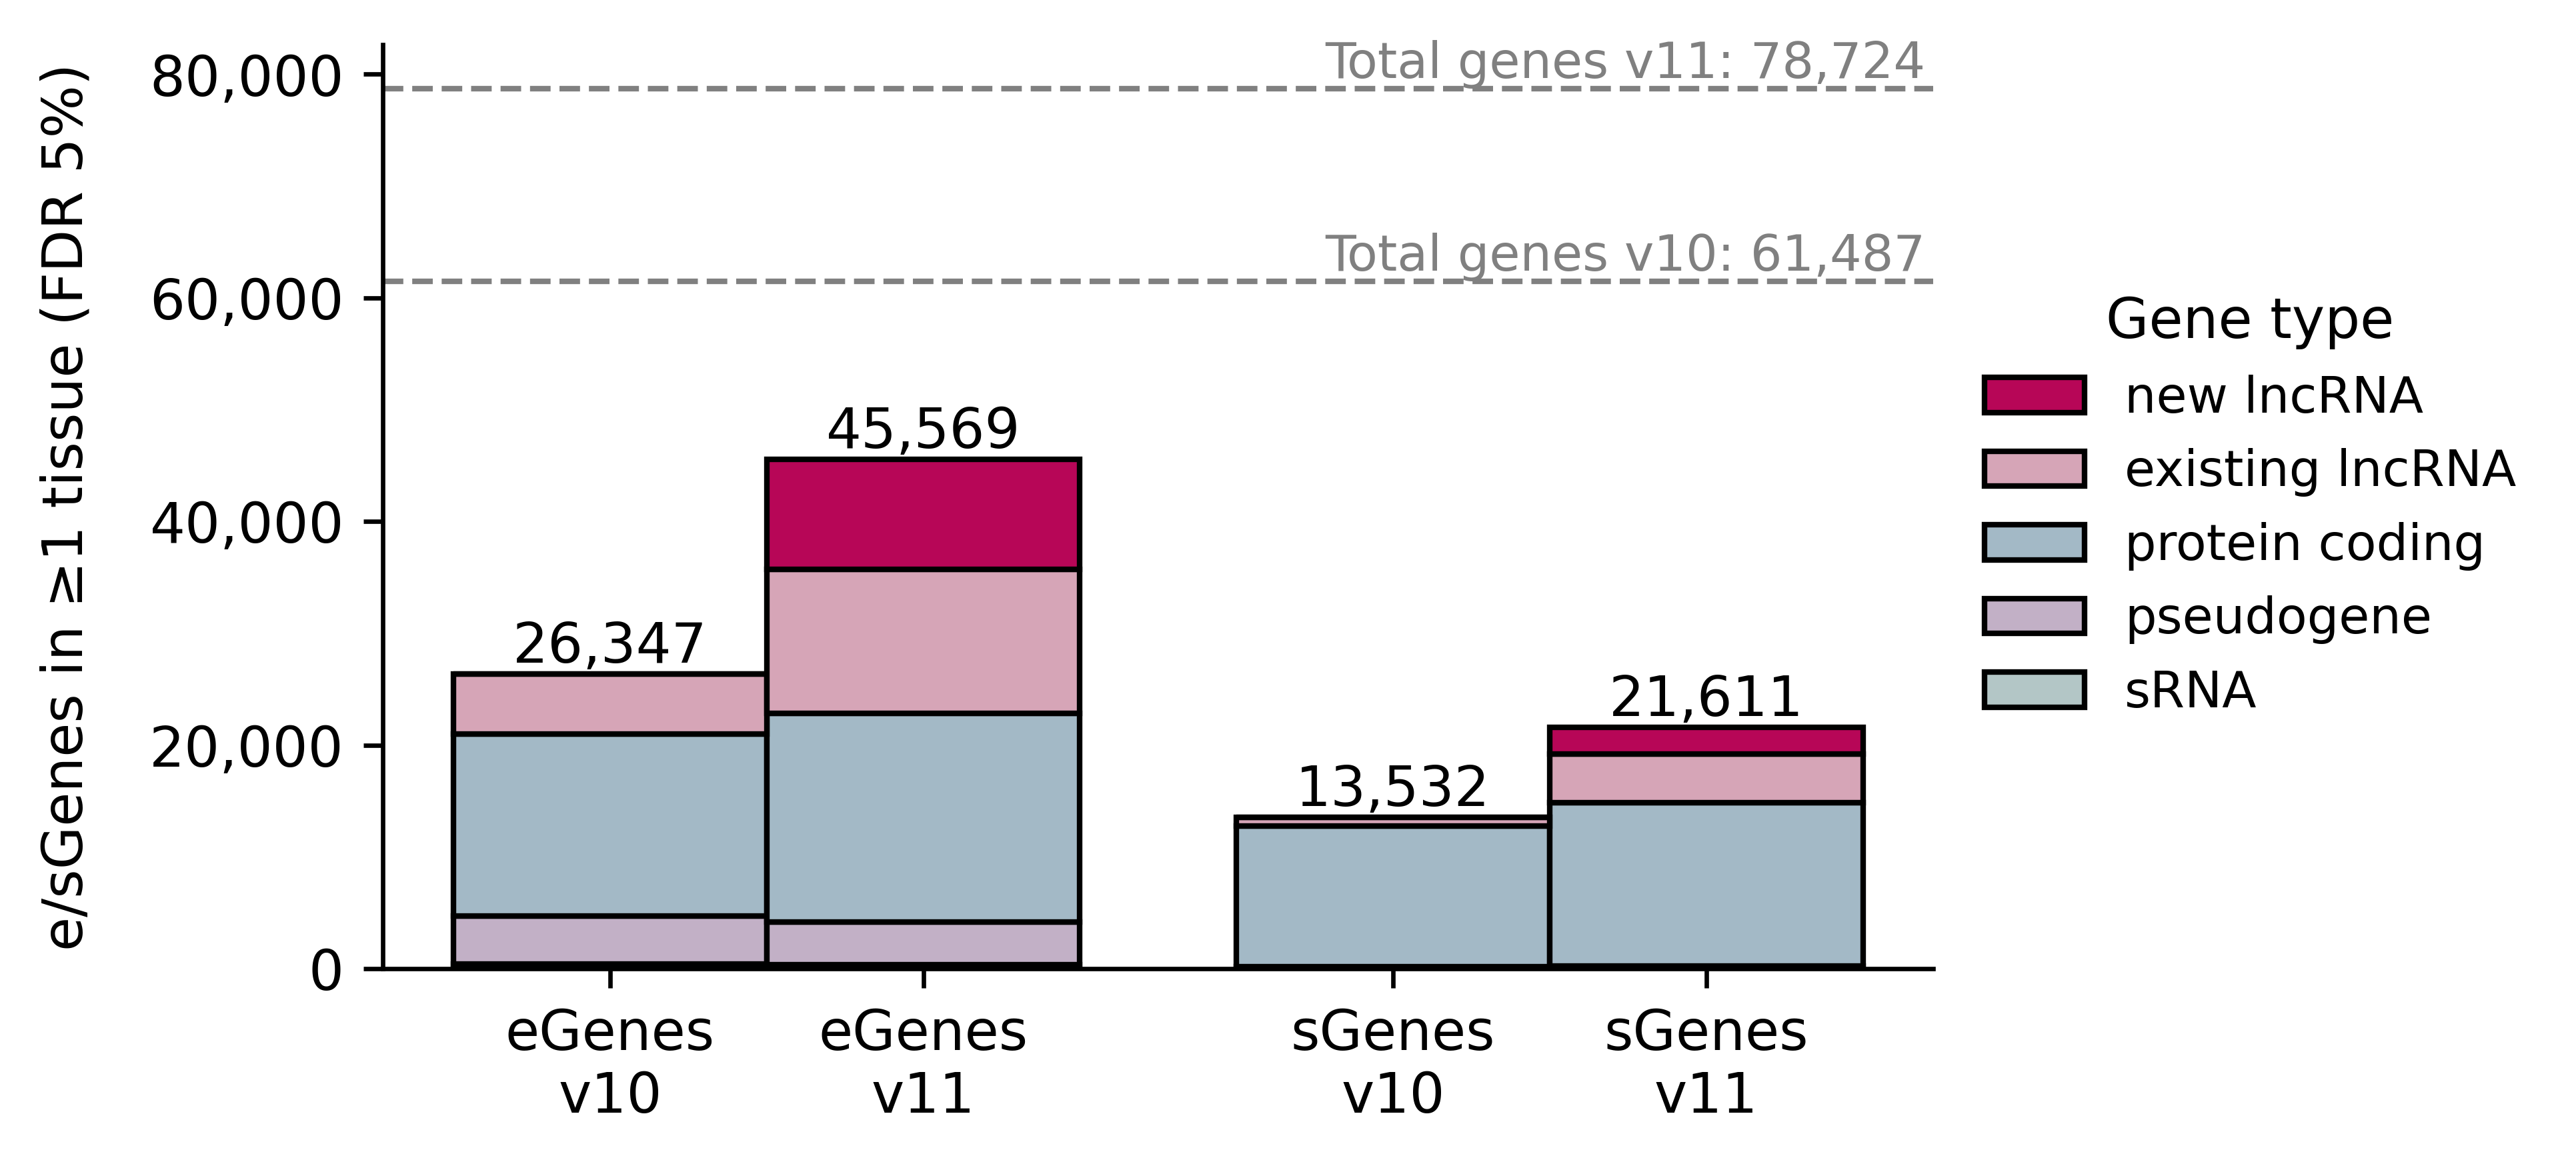

eGene: 26,347.0 (v10) -> 45,569.0 (v11), +73.0% change
sGene: 13,532.0 (v10) -> 21,611.0 (v11), +59.7% change


In [43]:
# Plot: Place eGene and sGene bars for v10 and v11 next to each other, add totals, and print % increase
qtl_order = ['eGene', 'sGene']
gene_type_order = ['sRNA', 'pseudogene', 'protein_coding', 'existing_lncRNA', 'new_lncRNA']
version_order = ['v10', 'v11']
fig, ax = plt.subplots(figsize=(5, 3), dpi=600)

bar_width = 1
n_versions = len(version_order)
n_qtl_types = len(qtl_order)
n_groups = n_versions * n_qtl_types

# Arrange bars so that for each QTL type, v10 and v11 are adjacent
x = []
xticklabels = []
bar_positions = {}
for i, qtl_type in enumerate(qtl_order):
    for j, version in enumerate(version_order):
        xpos = i * (n_versions + 0.5) + j  # Add 0.5 for spacing between QTL types
        x.append(xpos)
        xticklabels.append(f"{version}")
        bar_positions[(qtl_type, version)] = xpos

# Plot stacked bars for each gene type and collect bar tops for annotation
bar_tops = {k: 0 for k in range(len(x))}
bar_handles = []
for idx, gene_type in enumerate(gene_type_order):
    bottoms = [0] * len(x)
    if idx > 0:
        for k, (qtl_type, version) in enumerate([(qt, v) for qt in qtl_order for v in version_order]):
            prev_sum = sum([pivot.loc[(qtl_type, version)][gene_type_order[m]] for m in range(idx)])
            bottoms[k] = prev_sum
    heights = [pivot.loc[(qtl_type, version)][gene_type] for qtl_type in qtl_order for version in version_order]
    bars = ax.bar(
        x,
        heights,
        bar_width,
        bottom=bottoms,
        color=gene_type_pal_greyed[gene_type],
        edgecolor='black',
        label=gene_type.replace('_', ' '),  # For legend
    )
    if idx == 0:
        bar_handles.append(bars[0])
    else:
        bar_handles.append(bars[0])
    for k, h in enumerate(heights):
        bar_tops[k] += h

# Annotate total number at the top of each bar
for k, xpos in enumerate(x):
    total = bar_tops[k]
    ax.text(
        xpos, 
        total + max(bar_tops) * 0.01,  # Small offset above bar
        f"{int(total):,}", 
        ha='center', va='bottom', fontsize=10,
    )

# Add legend for gene types to the right side, in reverse order
ax.legend(
    handles=bar_handles[::-1],
    labels=[gt.replace('_', ' ') for gt in gene_type_order[::-1]],
    title="Gene type",
    bbox_to_anchor=(1.02, 0.5),
    loc='center left',
    borderaxespad=0,
    frameon=False,
    fontsize=9,
    title_fontsize=10
)
# Add horizontal lines for the total number of genes in v10 and v11 (non-NA gene_id_v47 and gene_id_v39)
total_genes_v11 = gencode_ids['gene_id_v47'].notna().sum()
total_genes_v10 = gencode_ids['gene_id_v39'].notna().sum()

# Draw horizontal lines across the plot for v10 and v11 totals
ax.axhline(total_genes_v10, color='grey', linestyle='--', linewidth=1)
ax.axhline(total_genes_v11, color='grey', linestyle='--', linewidth=1)

# Annotate the lines
ax.text(
    x[-1] + .7, total_genes_v10, 
    f"Total genes v10: {total_genes_v10:,}", 
    va='bottom', ha='right', color='grey', fontsize=9
)
ax.text(
    x[-1] + .7, total_genes_v11, 
    f"Total genes v11: {total_genes_v11:,}", 
    va='bottom', ha='right', color='grey', fontsize=9
)


ax.set_xticks(x)
ax.set_xticklabels(['eGenes\nv10', 'eGenes\nv11', 'sGenes\nv10', 'sGenes\nv11'], fontsize=10)
ax.set_ylabel('e/sGenes in ≥1 tissue (FDR 5%)', labelpad=10)
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: f'{int(x):,}' if x == int(x) else f'{x:,.2f}'))
sns.despine(ax=ax)
plt.show()

# Print % increase in eGenes and sGenes from v10 to v11
for qtl_type in qtl_order:
    n_v10 = pivot.loc[(qtl_type, 'v10')].sum()
    n_v11 = pivot.loc[(qtl_type, 'v11')].sum()
    if n_v10 > 0:
        pct_increase = 100 * (n_v11 - n_v10) / n_v10
        print(f"{qtl_type}: {n_v10:,} (v10) -> {n_v11:,} (v11), {pct_increase:+.1f}% change")
    else:
        print(f"{qtl_type}: {n_v10:,} (v10) -> {n_v11:,} (v11), n_v10 is zero, cannot compute % change")

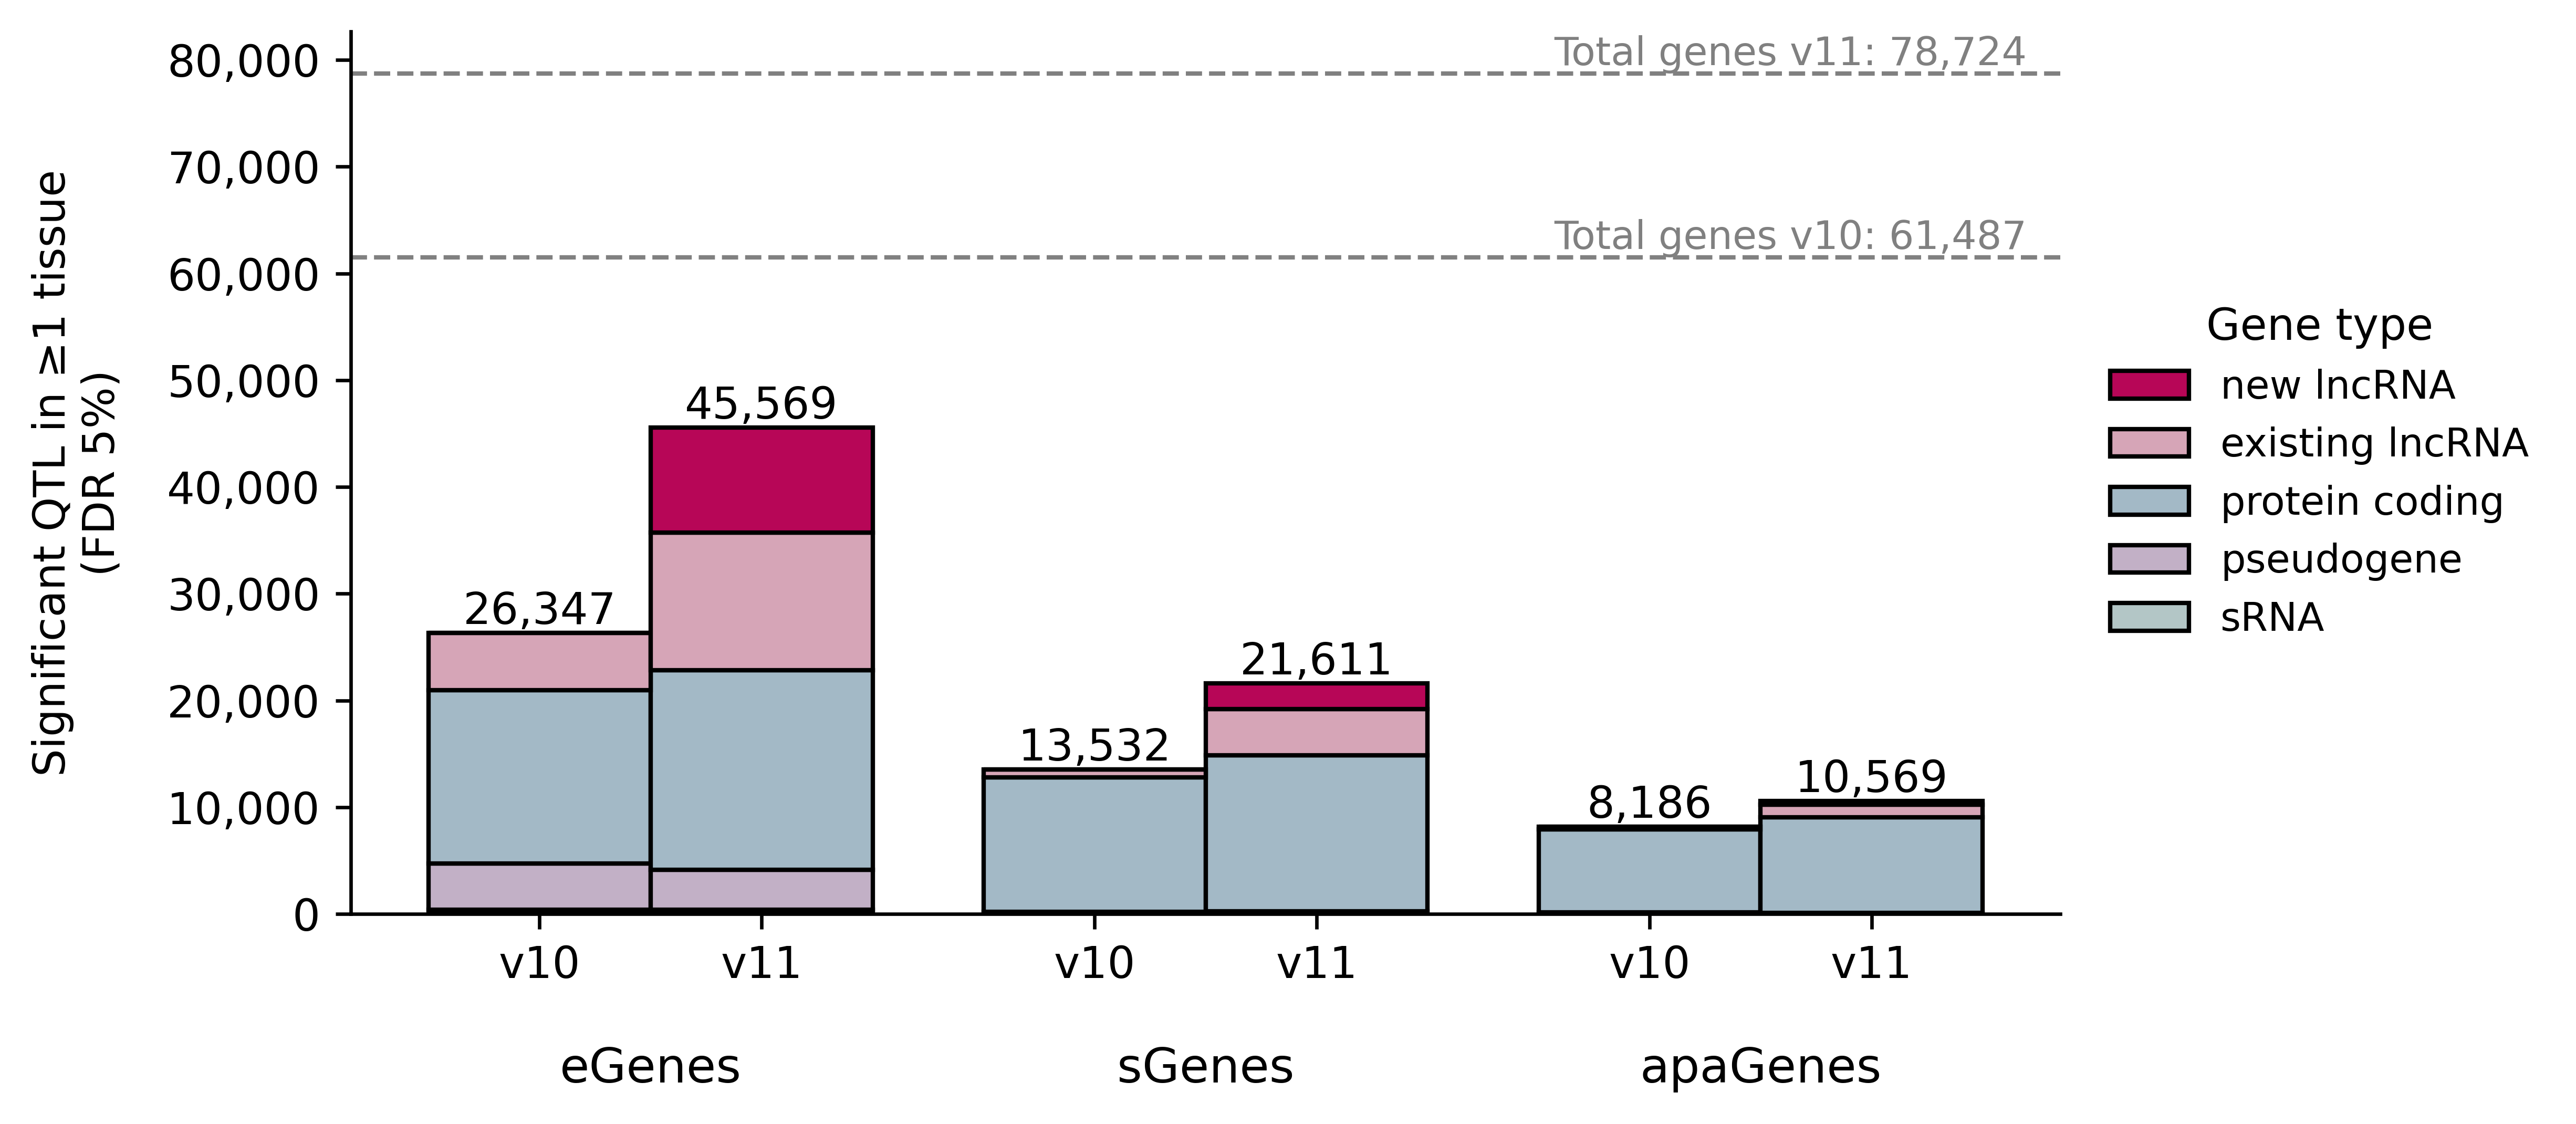

eGene: 26,347.0 (v10) -> 45,569.0 (v11), +73.0% change
sGene: 13,532.0 (v10) -> 21,611.0 (v11), +59.7% change
apaGene: 8,186.0 (v10) -> 10,569.0 (v11), +29.1% change


In [50]:
# Plot: Place eGene, sGene, and apaGene bars for v10 and v11 next to each other, add totals, and print % increase

# Expanded qtl_order to include 'apaGene'
expanded_qtl_order = ['eGene', 'sGene', 'apaGene']

fig, ax = plt.subplots(figsize=(7, 4), dpi=600)

bar_width = 1
n_versions = len(version_order)
n_qtl_types = len(expanded_qtl_order)
n_groups = n_versions * n_qtl_types

# Arrange bars so that for each QTL type, v10 and v11 are adjacent
x = []
xticklabels = []
bar_positions = {}
for i, qtl_type in enumerate(expanded_qtl_order):
    for j, version in enumerate(version_order):
        xpos = i * (n_versions + 0.5) + j  # Add 0.5 for spacing between QTL types
        x.append(xpos)
        xticklabels.append(f"{version}")
        bar_positions[(qtl_type, version)] = xpos

# Plot stacked bars for each gene type and collect bar tops for annotation
bar_tops = {k: 0 for k in range(len(x))}
bar_handles = []

# To avoid KeyError for missing (qtl_type, version) in pivot, always use .get() with default 0
for idx, gene_type in enumerate(gene_type_order):
    bottoms = [0] * len(x)
    if idx > 0:
        for k, (qtl_type, version) in enumerate([(qt, v) for qt in expanded_qtl_order for v in version_order]):
            prev_sum = 0
            for m in range(idx):
                # Use .get() to avoid KeyError for missing (qtl_type, version)
                if (qtl_type, version) in pivot.index and gene_type_order[m] in pivot.columns:
                    prev_sum += pivot.loc[(qtl_type, version)].get(gene_type_order[m], 0)
                else:
                    prev_sum += 0
            bottoms[k] = prev_sum
    # If (qtl_type, version) not in pivot, fill with zeros
    heights = []
    for qtl_type in expanded_qtl_order:
        for version in version_order:
            if (qtl_type, version) in pivot.index and gene_type in pivot.columns:
                heights.append(pivot.loc[(qtl_type, version)].get(gene_type, 0))
            else:
                heights.append(0)
    bars = ax.bar(
        x,
        heights,
        bar_width,
        bottom=bottoms,
        color=gene_type_pal_greyed[gene_type],
        edgecolor='black',
        label=gene_type.replace('_', ' '),  # For legend
    )
    bar_handles.append(bars[0])
    for k, h in enumerate(heights):
        bar_tops[k] += h

# Annotate total number at the top of each bar
for k, xpos in enumerate(x):
    total = bar_tops[k]
    ax.text(
        xpos, 
        total + max(bar_tops) * 0.01,  # Small offset above bar
        f"{int(total):,}", 
        ha='center', va='bottom', fontsize=10,
    )

# Add legend for gene types to the right side, in reverse order
ax.legend(
    handles=bar_handles[::-1],
    labels=[gt.replace('_', ' ') for gt in gene_type_order[::-1]],
    title="Gene type",
    bbox_to_anchor=(1.02, 0.5),
    loc='center left',
    borderaxespad=0,
    frameon=False,
    fontsize=9,
    title_fontsize=10
)
# Add horizontal lines for the total number of genes in v10 and v11 (non-NA gene_id_v47 and gene_id_v39)
total_genes_v11 = gencode_ids['gene_id_v47'].notna().sum()
total_genes_v10 = gencode_ids['gene_id_v39'].notna().sum()

# Draw horizontal lines across the plot for v10 and v11 totals
ax.axhline(total_genes_v10, color='grey', linestyle='--', linewidth=1)
ax.axhline(total_genes_v11, color='grey', linestyle='--', linewidth=1)

# Annotate the lines
ax.text(
    x[-1] + .7, total_genes_v10, 
    f"Total genes v10: {total_genes_v10:,}", 
    va='bottom', ha='right', color='grey', fontsize=9
)
ax.text(
    x[-1] + .7, total_genes_v11, 
    f"Total genes v11: {total_genes_v11:,}", 
    va='bottom', ha='right', color='grey', fontsize=9
)

# Set x-tick labels to just the versions (v10, v11) for each QTL type group
# and add a secondary label below, centered under each QTL type group

# Number of QTL types and versions
n_qtl = len(expanded_qtl_order)
n_ver = len(version_order)

# The x positions are ordered as: [eGene-v10, eGene-v11, sGene-v10, sGene-v11, apaGene-v10, apaGene-v11]
# So, for each QTL type, the two bars are at positions [i*2, i*2+1]
# We'll set the ticks at the center of each pair for the QTL type label, and at each bar for the version label

# Set version labels at each bar
version_labels = version_order * n_qtl  # ['v10', 'v11', 'v10', 'v11', ...]
ax.set_xticks(x)
ax.set_xticklabels(version_labels, fontsize=10)

# Add QTL type labels centered under each pair of bars
qtl_centers = [np.mean([x[i*n_ver], x[i*n_ver+1]]) for i in range(n_qtl)]
qtl_labels = []
for qtl_type in expanded_qtl_order:
    if qtl_type == 'eGene':
        qtl_labels.append('eGenes')
    elif qtl_type == 'sGene':
        qtl_labels.append('sGenes')
    elif qtl_type == 'apaGene':
        qtl_labels.append('apaGenes')
    else:
        qtl_labels.append(qtl_type)

# Draw the QTL type labels below the x-axis, centered under each pair
for xpos, label in zip(qtl_centers, qtl_labels):
    ax.text(
        xpos, 
        ax.get_ylim()[0] - (ax.get_ylim()[1] - ax.get_ylim()[0]) * 0.15,  # a bit below the axis
        label, 
        ha='center', va='top', fontsize=11,
    )

# Adjust the bottom margin to make room for the extra label
plt.subplots_adjust(bottom=0.18)
ax.set_ylabel('Significant QTL in ≥1 tissue\n(FDR 5%)', labelpad=10)
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: f'{int(x):,}' if x == int(x) else f'{x:,.2f}'))
sns.despine(ax=ax)
plt.show()

# Print % increase in eGenes, sGenes, and apaGenes from v10 to v11
for qtl_type in expanded_qtl_order:
    if (qtl_type, 'v10') in pivot.index:
        n_v10 = pivot.loc[(qtl_type, 'v10')].sum()
    else:
        n_v10 = 0
    if (qtl_type, 'v11') in pivot.index:
        n_v11 = pivot.loc[(qtl_type, 'v11')].sum()
    else:
        n_v11 = 0
    if n_v10 > 0:
        pct_increase = 100 * (n_v11 - n_v10) / n_v10
        print(f"{qtl_type}: {n_v10:,} (v10) -> {n_v11:,} (v11), {pct_increase:+.1f}% change")
    else:
        print(f"{qtl_type}: {n_v10:,} (v10) -> {n_v11:,} (v11), n_v10 is zero, cannot compute % change")

In [9]:
new_egenes = gencode_ids[gencode_ids['gene_type_grouped_highlight'].str.contains('lncRNA')]['is_egene'].sum() - gencode_ids[gencode_ids['gene_type_grouped_highlight'].str.contains('lncRNA')]['is_egene_v10'].sum()
new_sgenes = gencode_ids[gencode_ids['gene_type_grouped_highlight'].str.contains('lncRNA')]['is_sgene'].sum() - gencode_ids[gencode_ids['gene_type_grouped_highlight'].str.contains('lncRNA')]['is_sgene_v10'].sum()

print(f'{new_egenes} new egenes in v10 vs v11')
print(f'{new_sgenes} new sgenes in v10 vs v11')

17379 new egenes in v10 vs v11
5999 new sgenes in v10 vs v11


In [10]:
# load in tissue sample sizes
sample_meta = pd.read_csv('/home/klawren/oak/gtex/data/other_references/v10/GTEx_Analysis_v10_Annotations_SampleAttributesDS.txt', sep='\t')
passed_samples = sample_meta[sample_meta['SMAFRZE']=='RNASEQ']
num_samples = pd.DataFrame(passed_samples.groupby('SMTSD').size()).rename(columns={0:'num_samples'})

qtl_tissue_df = pd.merge(tissue_df, num_samples, left_on='tissue_name', right_on='SMTSD', how='left')
qtl_tissue_df = qtl_tissue_df[qtl_tissue_df['num_samples'] > 30]

/local/scratch/klawren/slrmtmp.48896882/ipykernel_627/961625645.py:2: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  sample_meta = pd.read_csv('/home/klawren/oak/gtex/data/other_references/v10/GTEx_Analysis_v10_Annotations_SampleAttributesDS.txt', sep='\t')


In [11]:
num_sgenes = gencode_ids[gencode_ids['gene_type_grouped_highlight']=='new_lncRNA'][sgene_cols].sum().reset_index(name='num_sgenes')
num_sgenes['tissue_file_name'] = num_sgenes['index'].str.split('.').str[0]
num_qtl_genes =pd.merge(qtl_tissue_df, num_sgenes[['num_sgenes', 'tissue_file_name']], on='tissue_file_name', how='left')

num_egenes = gencode_ids[gencode_ids['gene_type_grouped_highlight']=='new_lncRNA'][egene_cols].sum().reset_index(name='num_egenes')
num_egenes['tissue_file_name'] = num_egenes['index'].str.split('.').str[0]
num_qtl_genes =pd.merge(num_qtl_genes, num_egenes[['num_egenes', 'tissue_file_name']], on='tissue_file_name', how='left')

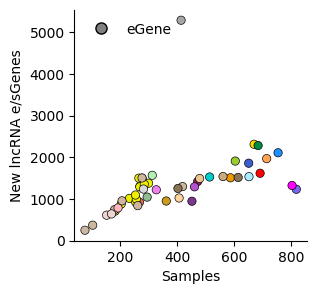

In [12]:
fig, ax = plt.subplots(figsize=(3, 3))
sns.scatterplot(data=num_qtl_genes, x='num_samples', y='num_egenes', hue='tissue_name', legend=False, palette=tissue_color_map, ax=ax, edgecolor='black')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Samples')
ax.set_ylabel('New lncRNA e/sGenes')

custom_legend = [
    Line2D([0], [0], marker='o', color='w', label='eGene', markerfacecolor='gray', markeredgecolor='black', markersize=8),
]
ax.legend(handles=custom_legend, loc='upper left', frameon=False, fontsize=10)


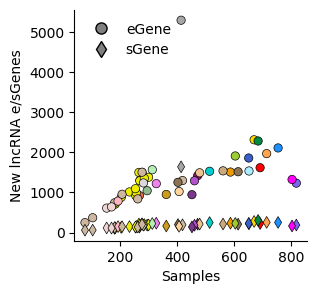

In [13]:
fig, ax = plt.subplots(figsize=(3, 3))
sns.scatterplot(data=num_qtl_genes, x='num_samples', y='num_egenes', hue='tissue_name', legend=False, palette=tissue_color_map, ax=ax, edgecolor='black')
sns.scatterplot(data=num_qtl_genes, x='num_samples', y='num_sgenes', hue='tissue_name', legend=False, marker='d', palette=tissue_color_map, ax=ax, edgecolor='black')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Samples')
ax.set_ylabel('New lncRNA e/sGenes')

custom_legend = [
    Line2D([0], [0], marker='o', color='w', label='eGene', markerfacecolor='gray', markeredgecolor='black', markersize=8),
    Line2D([0], [0], marker='d', color='w', label='sGene', markerfacecolor='gray', markeredgecolor='black', markersize=8)
]
ax.legend(handles=custom_legend, loc='upper left', frameon=False, fontsize=10)

Total new lncRNA genes:  18312
New lncRNA eGenes:  9829
New lncRNA sGenes:  2423


/local/scratch/klawren/slrmtmp.48896882/ipykernel_627/623346136.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bar_data, x='Gene type', y='Number of new lncRNA genes', palette=bar_colors, edgecolor='black', ax=ax)


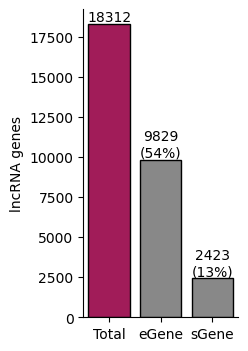

In [14]:
# Calculate counts for new lncRNA category
new_lncRNA_mask = gencode_ids['gene_type_grouped_highlight'] == 'new_lncRNA'
total_new_lncRNA = new_lncRNA_mask.sum()
num_new_lncRNA_egene = (new_lncRNA_mask & gencode_ids['is_egene']).sum()
num_new_lncRNA_sgene = (new_lncRNA_mask & gencode_ids['is_sgene']).sum()

print('Total new lncRNA genes: ', total_new_lncRNA)
print('New lncRNA eGenes: ', num_new_lncRNA_egene)
print('New lncRNA sGenes: ', num_new_lncRNA_sgene)

# Prepare bar data including total, eGene, and sGene
bar_data = pd.DataFrame({
    'Gene type': ['Total', 'eGene', 'sGene'],
    'Number of new lncRNA genes': [total_new_lncRNA, num_new_lncRNA_egene, num_new_lncRNA_sgene]
})

fig, ax = plt.subplots(figsize=(2, 4))
# Plot bars with the 'Total' bar in the new_lncRNA color, others in grey
bar_colors = [gene_type_pal_greyed['new_lncRNA'], '#888888', '#888888']
sns.barplot(data=bar_data, x='Gene type', y='Number of new lncRNA genes', palette=bar_colors, edgecolor='black', ax=ax)

# Add text labels on bars
for i, val in enumerate(bar_data['Number of new lncRNA genes']):
    if bar_data['Gene type'][i] == 'Total':
        ax.text(i, val, f"{val}", ha='center', va='bottom', color='black')
    else:
        ax.text(i, val, f"{val}\n({val/total_new_lncRNA:.0%})", ha='center', va='bottom', color='black')

ax.set_ylabel('lncRNA genes')
ax.set_xlabel('')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


/home/klawren/.pixi/envs/python/lib/python3.12/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/home/klawren/.pixi/envs/python/lib/python3.12/site-packages/upsetplot/plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting valu

dict_keys(['matrix', 'shading', 'totals', 'intersections'])


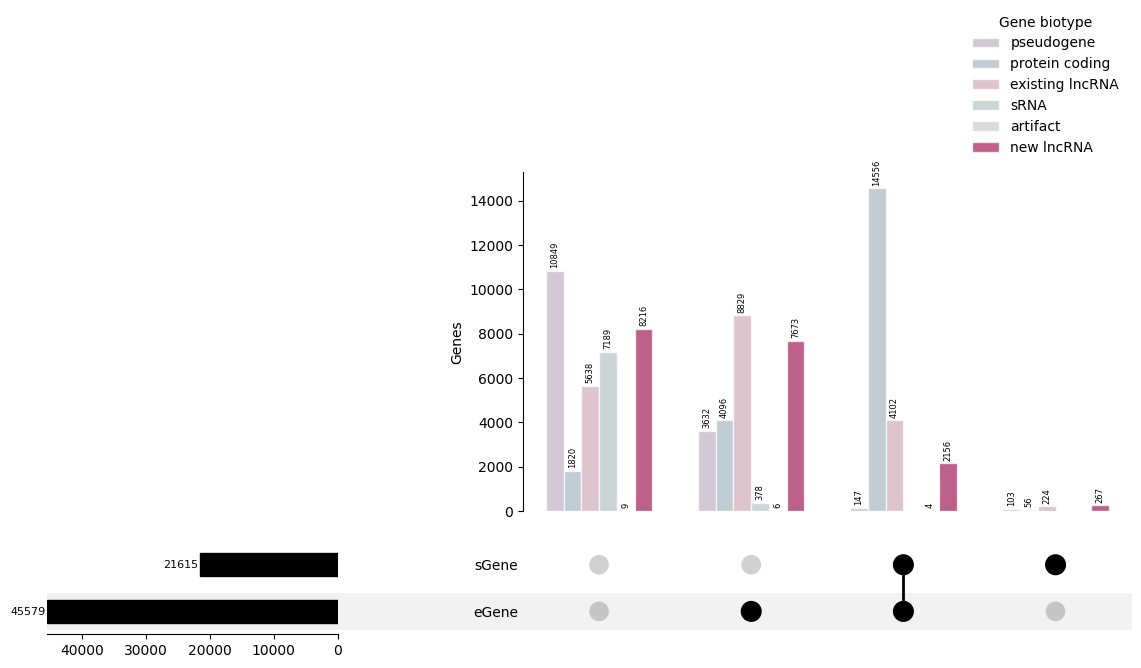

In [15]:
qtl_upset = up.from_indicators(gencode_ids[['is_egene', 'is_sgene']], data=gencode_ids['gene_type_grouped_highlight'])
qtl_upset.index.set_names(['eGene', 'sGene'], inplace=True)
qtl_upset = pd.DataFrame(qtl_upset)
qtl_upset_categories = qtl_upset.index.value_counts().index
category_to_idx = {category: idx for idx, category in enumerate(qtl_upset_categories)}
qtl_upset['idx_loc'] = qtl_upset.index.map(category_to_idx)

fig = plt.figure(figsize=(14, 6))
upset = up.UpSet(qtl_upset, show_counts=False, subset_size='count', intersection_plot_elements=6, totals_plot_elements=2, element_size=None, sort_by='cardinality')
plot_result = upset.plot(fig=fig, )

print(plot_result.keys())

totals_ax = plot_result['totals']
totals_ax.grid(False)
# add numbers to plot
for container in totals_ax.containers:
    totals_ax.bar_label(container, padding=1, fontsize=8,)

bar_ax = plot_result['intersections']
bar_ax.clear()
sns.countplot(qtl_upset, x='idx_loc', hue='gene_type_grouped_highlight',ax=bar_ax, palette=gene_type_pal_greyed, alpha=.7, edgecolor='white', width=.7)
bar_ax.set_ylabel('Genes')
#bar_ax.set_yscale('log')

# add numbers to plot
for container in bar_ax.containers:
    bar_ax.bar_label(container, padding=2, fontsize=6, rotation=90)

sns.move_legend(bar_ax, "upper right", bbox_to_anchor=(1, 1.5), frameon=False, title='Gene biotype')
legend = bar_ax.get_legend()
new_labels = [label.get_text().replace('_', ' ') for label in legend.texts]
for t, new_label in zip(legend.texts, new_labels):
    t.set_text(new_label)

cdf plot

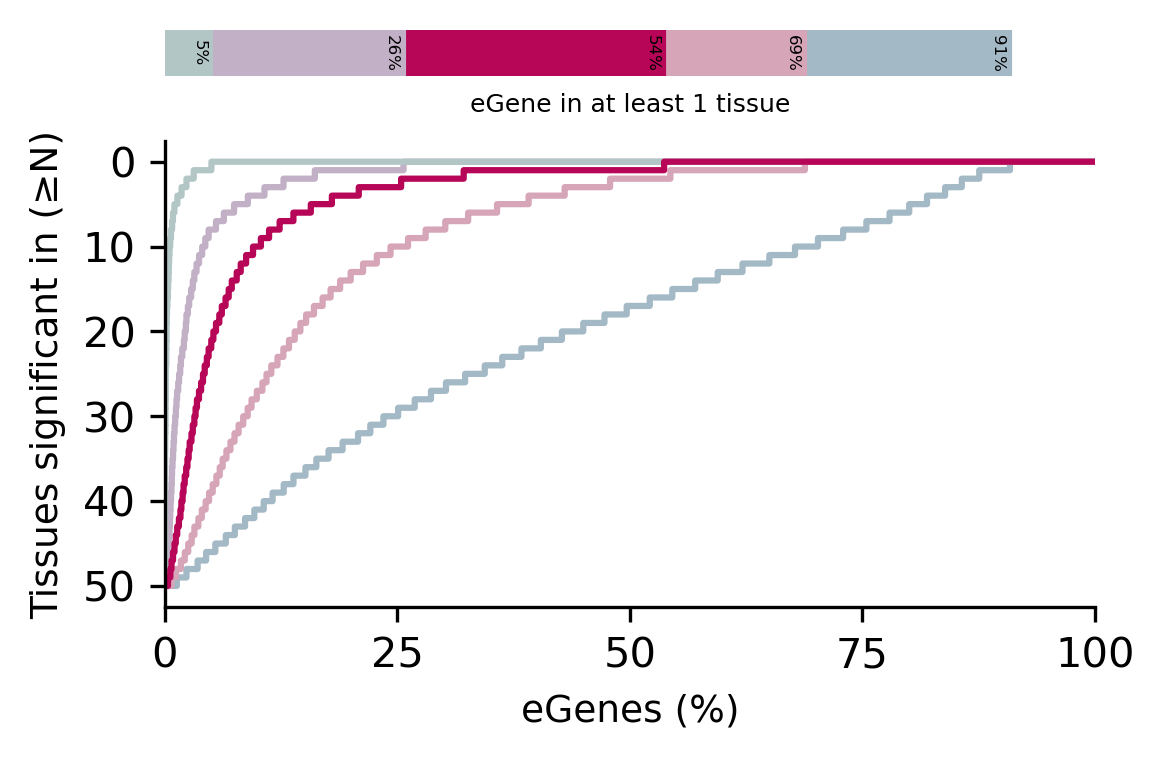

In [16]:
num_tissues = len(qtl_tissue_df)
gencode_ids['num_quantified'] = gencode_ids[egene_cols].sum(axis=1)

gencode_ids['num_not_quantified'] = num_tissues - gencode_ids['num_quantified'] 


zero_expr_props = (
    gencode_ids.groupby('gene_type_grouped_highlight')['num_not_quantified']
    .apply(lambda x: (x == num_tissues).mean())
    .reindex(['new_lncRNA', 'protein_coding', 'sRNA','pseudogene', 'existing_lncRNA'])
)

# Set up figure with two axes: bar on top, ECDF below
fig = plt.figure(figsize=(4, 2.5), dpi=300)
gs = fig.add_gridspec(2, 1, height_ratios=[.2, 2], hspace=0.25)
ax_bar = fig.add_subplot(gs[0])
ax = fig.add_subplot(gs[1])

# Horizontal stacked bar plot for proportion expressed in 0 tissues, sorted by value
sorted_zero_expr = zero_expr_props.sort_values(ascending=True)
bar_colors = [gene_type_pal_greyed[gt] for gt in sorted_zero_expr.index]

left = 0
for i, (idx, val) in enumerate(sorted_zero_expr.items()):
    ax_bar.barh(
        y=0,
        width=1-val,
        left=0,
        edgecolor=bar_colors[i],
        height=1.0,
        color=bar_colors[i],
        alpha=1.0,
        label=idx
    )
    # Add bar label at the center of each segment
    ax_bar.text(
        1-val-.005, 0,
        f"{1-val:.0%}",
        va='center',
        ha='right',
        color= 'k',
        fontsize=4,
        rotation=-90
    )

ax_bar.set_yticks([])
ax_bar.set_ylabel('')
ax_bar.set_xlim(0,1)
ax_bar.set_xlabel('eGene in at least 1 tissue', fontsize=6)
ax_bar.spines[['top', 'right', 'left', 'bottom']].set_visible(False)
ax_bar.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
ax_bar.tick_params(axis='y', length=2)

# ECDF plot for number of tissues expressed in, by gene type
sns.ecdfplot(
    ax=ax,
    data=gencode_ids,
    y='num_not_quantified',
    hue='gene_type_grouped_highlight',
    hue_order=['new_lncRNA', 'existing_lncRNA', 'protein_coding', 'sRNA','pseudogene'],
    palette=gene_type_pal_greyed, 
    linewidth=1.5
)

#ax.axhspan(49, 50, color='#E98300', alpha=0.3, lw=0, zorder=10, )  

ax.set_xlabel('eGenes (%)', fontsize=9)
ax.set_xticks([0, .25, .5, .75, 1])
ax.set_xticklabels([0, 25, 50, 75, 100])
ax.set_ylabel('Tissues significant in (≥N)', fontsize=9)
ax.set_yticks([0, 10, 20, 30, 40, 50])
ax.set_yticklabels([0, 10, 20, 30, 40, 50][::-1])
ax.spines[['top', 'right']].set_visible(False)
plt.setp(ax.get_legend(), visible=False)
plt.show()

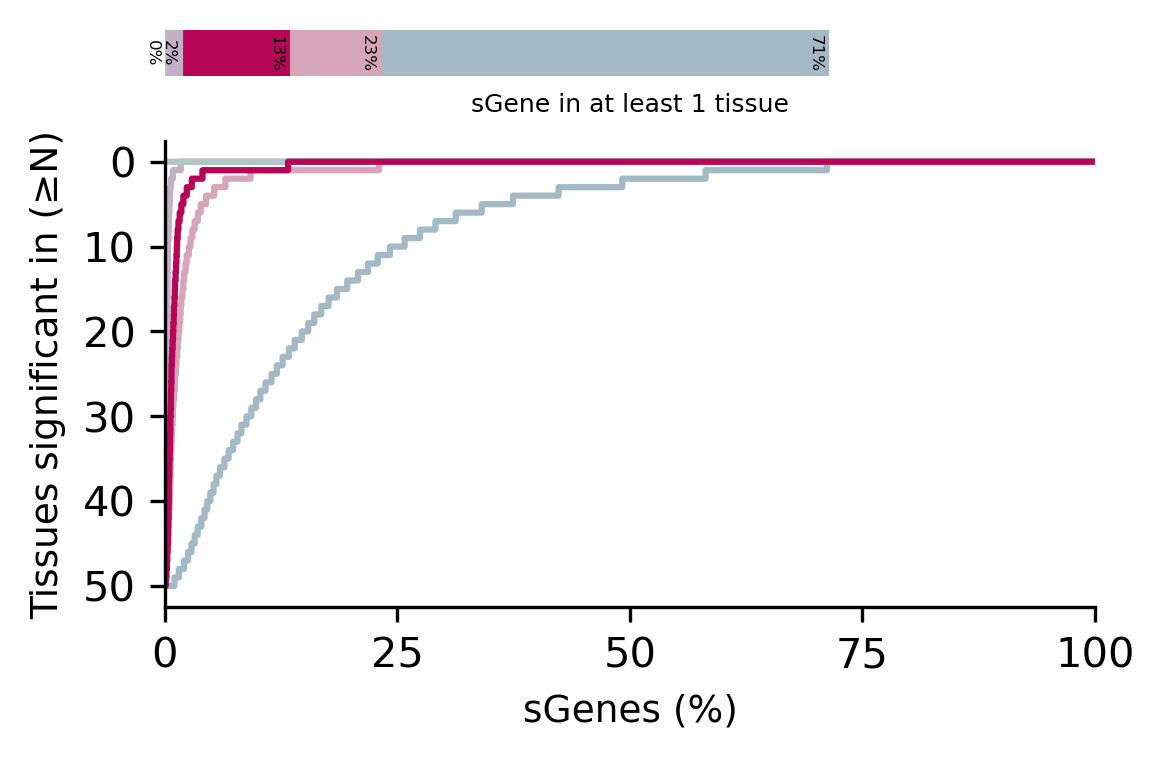

In [17]:
num_tissues = len(qtl_tissue_df)
gencode_ids['num_quantified'] = gencode_ids[sgene_cols].sum(axis=1)
gencode_ids['num_not_quantified'] = num_tissues - gencode_ids['num_quantified'] 


zero_expr_props = (
    gencode_ids.groupby('gene_type_grouped_highlight')['num_not_quantified']
    .apply(lambda x: (x == num_tissues).mean())
    .reindex(['new_lncRNA', 'protein_coding', 'sRNA','pseudogene', 'existing_lncRNA'])
)

# Set up figure with two axes: bar on top, ECDF below
fig = plt.figure(figsize=(4, 2.5), dpi=300)
gs = fig.add_gridspec(2, 1, height_ratios=[.2, 2], hspace=0.25)
ax_bar = fig.add_subplot(gs[0])
ax = fig.add_subplot(gs[1])

# Horizontal stacked bar plot for proportion expressed in 0 tissues, sorted by value
sorted_zero_expr = zero_expr_props.sort_values(ascending=True)
bar_colors = [gene_type_pal_greyed[gt] for gt in sorted_zero_expr.index]

left = 0
for i, (idx, val) in enumerate(sorted_zero_expr.items()):
    ax_bar.barh(
        y=0,
        width=1-val,
        left=0,
        edgecolor=bar_colors[i],
        height=1.0,
        color=bar_colors[i],
        alpha=1.0,
        label=idx
    )
    # Add bar label at the center of each segment
    ax_bar.text(
        1-val-.005, 0,
        f"{1-val:.0%}",
        va='center',
        ha='right',
        color= 'k',
        fontsize=4,
        rotation=-90
    )

ax_bar.set_yticks([])
ax_bar.set_ylabel('')
ax_bar.set_xlim(0,1)
ax_bar.set_xlabel('sGene in at least 1 tissue', fontsize=6)
ax_bar.spines[['top', 'right', 'left', 'bottom']].set_visible(False)
ax_bar.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
ax_bar.tick_params(axis='y', length=2)

# ECDF plot for number of tissues expressed in, by gene type
sns.ecdfplot(
    ax=ax,
    data=gencode_ids,
    y='num_not_quantified',
    hue='gene_type_grouped_highlight',
    hue_order=['new_lncRNA', 'existing_lncRNA', 'protein_coding', 'sRNA','pseudogene'],
    palette=gene_type_pal_greyed, 
    linewidth=1.5
)

#ax.axhspan(49, 50, color='#E98300', alpha=0.3, lw=0, zorder=10, )  

ax.set_xlabel('sGenes (%)', fontsize=9)
ax.set_xticks([0, .25, .5, .75, 1])
ax.set_xticklabels([0, 25, 50, 75, 100])
ax.set_ylabel('Tissues significant in (≥N)', fontsize=9)
ax.set_yticks([0, 10, 20, 30, 40, 50])
ax.set_yticklabels([0, 10, 20, 30, 40, 50][::-1])
ax.spines[['top', 'right']].set_visible(False)
plt.setp(ax.get_legend(), visible=False)
plt.show()